# Doc2Vec

In [59]:
import collections
import glob
from itertools import chain
import numpy as np
import tensorflow as tf

In [60]:
files = glob.glob('*.txt')

words = []
for f in files:
    file = open(f)
    words.append(file.read())
    file.close()

words = list(chain.from_iterable(words))
words = ''.join(words)[:-1]
sentences = words.split('\n')

In [62]:
vocabulary_size = 40000

def build_dataset(sentences):
    words = ''.join(sentences).split()
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    unk_count = 0
    sent_data = []
    for sentence in sentences:
        data = []
        for word in sentence.split():
            if word in dictionary:
                index = dictionary[word]
            else:
                index = 0  # dictionary['UNK']
                unk_count = unk_count + 1
            data.append(index)
        sent_data.append(data)
    
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return sent_data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(sentences)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:2])
# del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 97415], ('the', 667723), ('and', 324431), ('a', 322940), ('of', 289409)]
Sample data [[279, 174, 436, 7048, 46, 3381, 43, 3, 15, 16, 223, 1129, 72, 1707, 1166, 37, 1, 1308, 1603, 2144, 836, 4, 61, 39, 25, 53, 172, 9, 41, 117, 23, 453, 44, 99, 4, 1, 101, 89, 4, 178, 27, 2991, 8, 1, 4180, 2, 7048, 12, 104, 25, 1654, 399, 22, 2, 92, 1501, 364, 73, 304, 33, 61, 57, 9, 117, 23, 453, 1, 104, 70, 142, 64, 453, 44, 6, 3, 53, 9629, 34013, 9799, 9168, 1, 444, 6, 24, 269, 122, 14, 516, 35, 1237, 24, 12, 127, 72, 244, 322, 184, 86, 2, 273, 56, 3794, 4, 3, 17093, 4180, 26, 62, 13182, 721, 5, 29, 1705, 121, 7048, 414, 51, 70, 25, 69, 501, 1, 302, 95, 218, 4, 10, 3890, 7048, 704, 178, 30, 44, 9168, 12, 2991, 70, 25, 556, 134, 9168, 6, 2098, 5, 29, 1, 118, 17, 56, 2521, 15410, 40, 11272, 56, 1314, 129, 7, 13, 30, 9, 96, 78, 5, 386, 37, 1595, 7, 122, 34, 519, 8], [10, 6, 34, 464, 4, 134, 1, 2219, 4, 205, 105, 25, 1, 168, 3854, 2, 347, 39, 12, 64, 163, 276, 149, 129, 3,

## Tensorflow Model

In [65]:
skip_window = 3
instances = 0
for sentence  in data:
    instances += len(sentence)-2*skip_window
print(instances)    

11408957


In [66]:
context = np.zeros((instances,skip_window*2),dtype=np.int32)
labels = np.zeros((instances,1),dtype=np.int32)
doc = np.zeros((instances,1),dtype=np.int32)

k = 0
for doc_id, sentence  in enumerate(data):
    for i in range(skip_window, len(sentence)-skip_window):
        buffer = sentence[i-skip_window:i+skip_window+1]
        del buffer[skip_window]
        labels[k] = sentence[i]
        context[k] = buffer
        doc[k] = doc_id
        k += 1
        
shuffle_idx = np.random.permutation(k)
labels = labels[shuffle_idx]
doc = doc[shuffle_idx]
context = context[shuffle_idx]

In [116]:
batch_size = 256
context_window = 2*skip_window
embedding_size = 50 # Dimension of the embedding vector.
softmax_width = embedding_size # +embedding_size2+embedding_size3
num_sampled = 100 # Number of negative examples to sample.
sum_ids = np.repeat(np.arange(batch_size),context_window)

len_docs = len(data)

graph = tf.Graph()

with graph.as_default(): # , tf.device('/cpu:0')
    # Input data.
    train_word_dataset = tf.placeholder(tf.int32, shape=[batch_size*context_window])
    train_doc_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    segment_ids = tf.constant(sum_ids, dtype=tf.int32)

    word_embeddings = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
    doc_embeddings = tf.Variable(tf.random_uniform([len_docs,embedding_size],-1.0,1.0))

    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, softmax_width],
                             stddev=1.0 / np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed_words = tf.segment_sum(tf.nn.embedding_lookup(word_embeddings, train_word_dataset),segment_ids)
    embed_docs = tf.nn.embedding_lookup(doc_embeddings, train_doc_dataset)
    embed = embed_words+embed_docs#+embed_hash+embed_users

    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.nce_loss(softmax_weights, softmax_biases, embed,
                                   train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)
        
    norm = tf.sqrt(tf.reduce_sum(tf.square(doc_embeddings), 1, keep_dims=True))
    normalized_doc_embeddings = doc_embeddings / norm

In [117]:
############################
# Chunk the data to be passed into the tensorflow Model
###########################
data_idx = 0
def generate_batch(batch_size):
    global data_idx

    if data_idx+batch_size<len_docs:
        batch_labels = labels[data_idx:data_idx+batch_size]
        batch_doc_data = doc[data_idx:data_idx+batch_size]
        batch_word_data = context[data_idx:data_idx+batch_size]
        data_idx += batch_size
    else:
        overlay = batch_size - (len_docs-data_idx)
        batch_labels = np.vstack([labels[data_idx:len_docs],labels[:overlay]])
        batch_doc_data = np.vstack([doc[data_idx:len_docs],doc[:overlay]])
        batch_word_data = np.vstack([context[data_idx:len_docs],context[:overlay]])
        data_idx = overlay
    batch_word_data = np.reshape(batch_word_data,(-1,1))

    return batch_labels, batch_word_data, batch_doc_data

In [118]:
num_steps = 1000001
step_delta = int(num_steps/20)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_labels, batch_word_data, batch_doc_data\
        = generate_batch(batch_size)
        feed_dict = {train_word_dataset : np.squeeze(batch_word_data),
                     train_doc_dataset : np.squeeze(batch_doc_data),
                     train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % step_delta == 0:
            if step > 0:
                average_loss = average_loss / step_delta
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0

    # Get the weights to save for later
#     final_doc_embeddings = normalized_doc_embeddings.eval()
    final_word_embeddings = word_embeddings.eval()
    final_word_embeddings_out = softmax_weights.eval()
    final_doc_embeddings = normalized_doc_embeddings.eval()

Initialized
Average loss at step 0: 426.157104
Average loss at step 50000: 7.854996
Average loss at step 100000: 0.641150
Average loss at step 150000: 0.603961
Average loss at step 200000: 0.594481
Average loss at step 250000: 0.589963
Average loss at step 300000: 0.586765
Average loss at step 350000: 0.584712
Average loss at step 400000: 0.583086
Average loss at step 450000: 0.582070
Average loss at step 500000: 0.581260
Average loss at step 550000: 0.580287
Average loss at step 600000: 0.579365
Average loss at step 650000: 0.579081
Average loss at step 700000: 0.578365
Average loss at step 750000: 0.578061
Average loss at step 800000: 0.577644
Average loss at step 850000: 0.577144
Average loss at step 900000: 0.576824
Average loss at step 950000: 0.576325
Average loss at step 1000000: 0.576282


In [172]:
rand_doc = np.random.randint(len_docs)
dist = final_doc_embeddings.dot(final_doc_embeddings[rand_doc][:,None])
closest_doc = np.argsort(dist,axis=0)[-4:][::-1]

for idx in closest_doc:
    print(dist[idx][0][0])

1.0
0.584714
0.526221
0.516274


In [173]:
sentences[rand_doc]

'peter crawford discovers a comet on a collision course with the moon but when the government doesn t believe him dumb fact he builds a shelter in deep underground and is drawing lots to see who will go plus is willing to kill to save humanity dumb fact with millions of dollars of technology how could a civilian see what nasa could not plus the ends justifies the means moral of this story is just plain wrong this movie is improbable and totally unbelievable what was running through these people minds why the hell do crap piles like this get the green light some times i wonder who someone has to to get a movie made in this ing town '

In [174]:
sentences[closest_doc[1][0]]

'wow i don t even really remember that much about this movie except that it stunk the plot s basically a girl s parents neglect her so this sicko pokemon pretends to be her dad am i the only one disturbed by that then this weirdo pokemon kidnaps ash s mom to pretend to be the girl s i don t care if he was trying to make the girl happy that s just gross there was no real plot the girl was just a whiny brat who wanted things her own way she played with unowns was the daughter of entei and apparently could grow and shrink in age on a whim with the help of her dad that s pretty much all i can remember but i think you can take it as a hint and not see it or if you do see it don t expect much out of seriously if you want a pokemon movie rent pokemon the first movie '

In [175]:
sentences[closest_doc[2][0]]

'this is very much not the sort of movie for which john wayne is known he plays a diplomat a man who gets things done through words and persuasion rather than physical action the film moves with a quiet realism through its superficially unexciting story for the open minded the patient and the thoughtful this movie is a rich depiction of an intriguing part of history there are two intertwining stories the big story is of internalised isolationist japan and externalised expansionist america clashing when their interests conflict the small human story is of an outsider barbarian wayne and a civilised geisha s initial hostility and dislike turning to mutual respect and love the human story is a reflection of the greater story of the two nations the movie is very well done and all actors play their roles well the two lead roles are performed to perfection john wayne is excellent as townsend harris striking exactly the right blend of force and negotiation in his dealings with the japanese ei

In [176]:
sentences[closest_doc[3][0]]

'this movie start quite gruesomely with a female being bound and psychologically tortured there s male full frontal nudity dead animal parts dogs licking nipples the female loosing control of her bladder all shot in a gray cold color effective but a little too much we then move on to seeing the btk killer s youth as well as the present and his history of crimes the tension is entirely psychological and the scenes of the killer entering the homes of his victims and talking to them lasts for quite a long time and it s creepy here we don t see fancy or good imagery it looks as if shot with your home camera it doesn t look horrifying but in a way seeing a criminal engage his victims for quite some time before killing them is quite unusual and chilling what this movie doesn t have is any drama really there are some cop scenes every once in a while but there s no excitement in terms of them finding the killer there isn t much of an arc to this story this could have been an effective psycholo

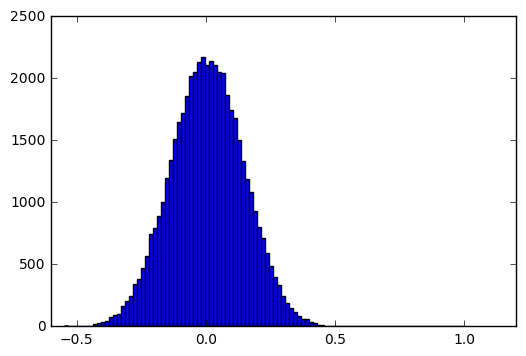

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(dist,100)
plt.show()

## Gensim Model

In [139]:
import gensim
from gensim.models import Doc2Vec
from multiprocessing import cpu_count

cpus = cpu_count()

In [148]:
def read_corpus():
    for i,sentence in enumerate(words.split('\n')):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(sentence), [i])

train_corpus = list(read_corpus())

In [155]:
model = Doc2Vec(dm=1, dm_concat=0, size=embedding_size, window=skip_window, 
                negative=5,hs=0, min_count=5, workers=cpus, iter=2)
model.build_vocab(train_corpus)

In [156]:
%%time
model.train(train_corpus)

CPU times: user 26min 22s, sys: 1.86 s, total: 26min 23s
Wall time: 3min 26s


21854570

In [182]:
closest_doc2 = model.docvecs.most_similar([model.docvecs[rand_doc]],topn=4)
for _, sim in closest_doc2:
    print(sim)

1.0
0.8846234083175659
0.8725295066833496
0.8673354387283325


In [178]:
sentences[rand_doc]

'peter crawford discovers a comet on a collision course with the moon but when the government doesn t believe him dumb fact he builds a shelter in deep underground and is drawing lots to see who will go plus is willing to kill to save humanity dumb fact with millions of dollars of technology how could a civilian see what nasa could not plus the ends justifies the means moral of this story is just plain wrong this movie is improbable and totally unbelievable what was running through these people minds why the hell do crap piles like this get the green light some times i wonder who someone has to to get a movie made in this ing town '

In [179]:
sentences[closest_doc2[1][0]]

'the title of this documentary is very misleading at no time during the documentary do they show how the introduction of the nile perch fish into lake victoria has cause any of the problems facing the town of mwanza tanzania the film tries to place the problems of tanzania on an environmental cause but the truth of that matter is the problems stem from a parasitic outside force the documentary is very slowing paced with no narrative what so ever instead it relies on small blips of text between none related segments to display bits of information that do little to add or expand of the subject matter there are only two attempts to discus the environmental effects of the nile perch fish one is a small segment about seconds long where they interview the factory managers where the fish is processed and he briefly mentions how years ago the nile perch was introduced into the lake and it consumed the other fish species the film maker makes no attempt to follow up on the matter or go deeper in

In [180]:
sentences[closest_doc2[2][0]]

'this could have been great the voice overs are exactly right and fit the characters to a t one small problem though the look of the characters mostly the supporting or guest characters look exactly the same the same bored look on every face only with minor changes such as hairlines or weight size it looks kind of odd to see a really big guest star s voice coming out of a lifeless form like the characters here if i am not mistaken kathy griffin did a voice over for this show and it looked too odd to be funny there is a few other problems one being the family plot the simpsons did it much better where you could actually buy most of the situations the characters got themselves into here we get too much annoying diversions like someone having a weird fantasy and then we are supposed to find that funny but for some reason the delivery is a bit off as you can probably tell it is hard for me to put a finger on exactly what is wrong with this show because it basically nothing more than a clon

In [181]:
sentences[closest_doc2[3][0]]

'i like many folks believe the epic lonesome dove was one of the best westerns ever produced maybe the best and realizing that most sequels in this case a prequel are certain to disappoint my expectations were low comanche moon met that expectation with its marginal directing and acting poor casting and frankly a lousy script lonesome dove created western heroes of captains mccrae and call due to incredibly strong performances by robert duvall and tommy lee jones prior to living in lonesome dove we believed they bravely fought to rid texas of bandits and savage indians during their rangering years if i had only seen comanche moon i would think these two boneheads were a couple of incompetent cowardly idiots in lonesome dove call and mccrae supposedly chased blue duck all over texas and never managed to capture or kill him in comanche moon a shot to call s boot heel convinced him to settle down and raise cattle there wasn t a decent fistfight or gun fight in the entire miniseries the be